In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sonnmf.numba.main import sonnmf
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [16]:
def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

def plot_separate_H(H, img_size, figsize, fontsize, num_rows=4, normalize_row=False, filename=None):
    rank = H.shape[0]
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    num_cols = int(np.ceil(rank / num_rows))
    if num_rows > 1:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
        cnt = 0
        for i in range(num_rows):
            for j in range(num_cols):
                if cnt < rank:
                    img = axs[i, j].imshow(H3d[cnt, :, :], cmap='gray')
                    axs[i, j].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
                    axs[i, j].axis('off')
                    divider = make_axes_locatable(axs[i, j])
                    cax = divider.append_axes('right', size='5%', pad=0.1)
                    fig.colorbar(img, cax=cax, orientation='vertical')
                else:
                    axs[i, j].axis('off')
                cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            cnt += 1
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
        plt.close()


def plot_combined_H(H, img_size, figsize, num_rows=1, normalize_row=False, filename=None):
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()


def plot_W_mats(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel()

    for cnt, ax in enumerate(axs):
        if cnt < rank:
            ax.plot(W[:, cnt], linewidth=3)
            if scale_y:
                ax.set_ylim([min(0, wmin), wmax])

            ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            ax.set_xlabel('Bands')
            ax.set_ylabel('Reflectance')
        else:
            ax.axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()

def merge_images(images_list, filename, delete_images=False):
    imgs = [Image.open(i) for i in images_list]
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
        total_height += imgs[i].height

    img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

def plot_and_merge(W, H, imgsize, figsize, fontsize, filenames, num_rows, delete=False):
    plot_W_mats(W, figsize, fontsize=fontsize, n_rows=num_rows, filename=filenames[0])
    plot_separate_H(H, imgsize, figsize=figsize, fontsize=fontsize, num_rows=num_rows, filename=filenames[1])
    plot_combined_H(H, imgsize, figsize=figsize, num_rows=num_rows, filename=filenames[2])
    merge_images(filenames[:3], filenames[3], delete_images=delete)


def plot_scores(fscores, gscores, hscores, total_scores):
    scores = np.array([fscores, gscores, hscores, total_scores]).T

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plotting scores
    ax1 = axes[0]
    ax1.plot(scores)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Scores')
    ax1.set_title('Scores Comparison')
    ax1.grid(True)
    ax1.legend(['f', 'g', 'h', 'total'])
    ax1.set_yscale('log')

    # Plotting scores_diff
    ax2 = axes[1]
    ax2.plot(scores - scores.min(axis=0, keepdims=True))
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('(Score - Min(Score))')
    ax2.set_title('Scores Difference')
    ax2.grid(True)
    ax2.legend(['f', 'g', 'h', 'total'])
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

In [17]:
data_filepath = '../datasets/urban_full.npz'
ini_filepath = '../saved_models/urban_full/r{}_ini.npz'
save_filepath = '../saved_models/urban_full/r{}_l{}_g{}_it{}.npz'
image_filepath = '../images/urban_full/r{}_l{}_g{}_it{}.jpg'

In [18]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape
r = 20

In [19]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [22]:
lams = [100_000, 500_000, 1_000_000, 5_000_000]
gammas = [100_000, 500_000, 1_000_000, 5_000_000]
it_checkpoints = [1000]

for i, iters in enumerate(it_checkpoints):
    for g in gammas:
        for l in lams:
            if not os.path.exists(save_filepath.format(r, l , g, iters)):
                if i == 0:
                    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=l, gamma=g, itermax=iters, W_update_iters=10, early_stop=True, verbose=False)
                    save_results(save_filepath.format(r, l , g, iters), W, H, fscores, gscores, hscores, total_scores)

                else:
                    old_W, old_H, old_fscores, old_gscores, old_hscores, old_total_scores = load_results(save_filepath.format(r, l , g, it_checkpoints[i-1]))
                    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, old_W.copy(), old_H.copy(), lam=l, gamma=g, itermax=iters - it_checkpoints[i-1], W_update_iters=10, early_stop=True, verbose=False)
                    fscores = np.concatenate((old_fscores[:-1], fscores))
                    gscores = np.concatenate((old_gscores[:-1], gscores))
                    hscores = np.concatenate((old_hscores[:-1], hscores))
                    total_scores = np.concatenate((old_total_scores[:-1], total_scores))
                    save_results(save_filepath.format(r, l , g, iters), W, H, fscores, gscores, hscores, total_scores)
            print(iters, g, l)

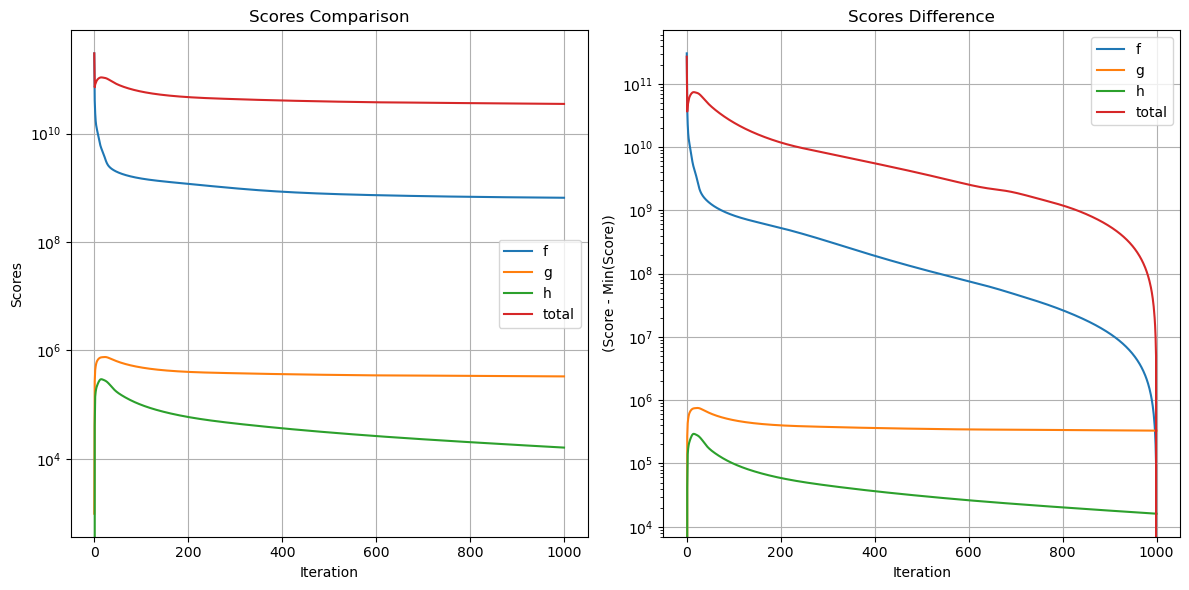

1000 100000 100000


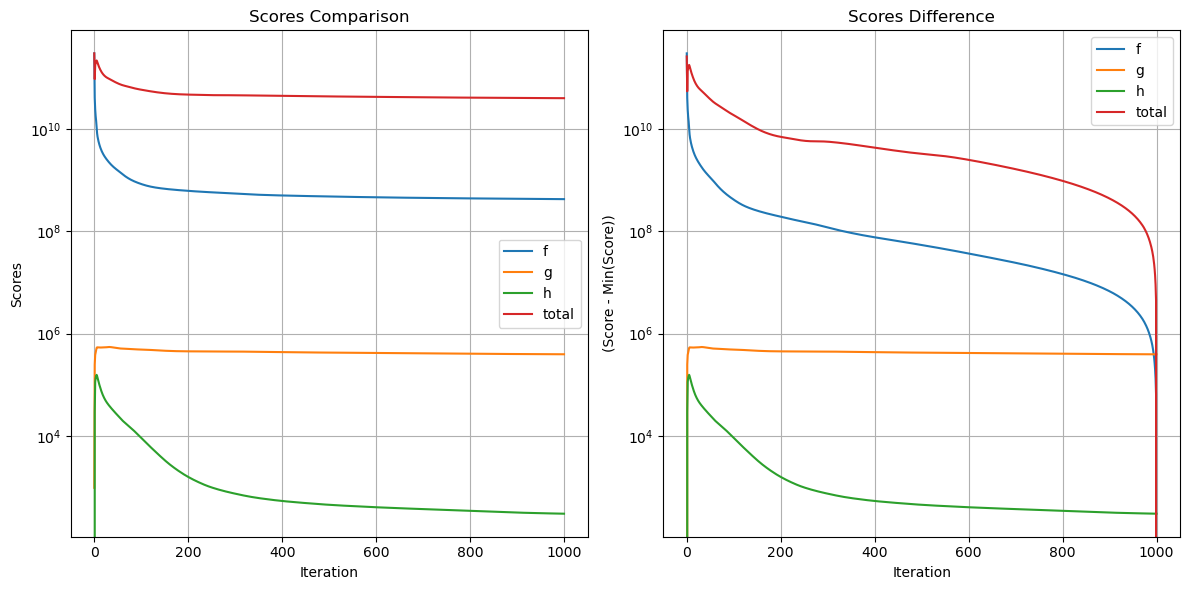

1000 1000000 100000


In [27]:
# for iters in it_checkpoints:
#     for g in gammas:
#         for l in lams[:1]:
#             if os.path.exists(save_filepath.format(r, l , g, iters)) and not os.path.exists(image_filepath.format(r, l , g, iters)):
#                 W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath.format(r, l , g, iters))
#                 fns = ['../images/tmp_w.jpg', '../images/tmp_seph.jpg', '../images/tmp_combh.jpg', image_filepath.format(r, l , g, iters)]
#                 plot_and_merge(W, H, (307, 307), (24, 6), 16, fns, 2, delete=True)
#                 # plot_and_merge(W, H, (100, 100), (24, 6), 16, fns, 2, delete=True)
#                 # plot_and_merge(W, H, (8, 8), (24, 24), 16, fns, 8, delete=True)
#                 plot_scores(fscores, gscores, hscores, total_scores)
#                 print(iters, g, l)